# Reinforcement Learning of Social Distancing during COVID-19 with a Confounder

## COVID-19 Model

#### We use an SEIHRD (Susceptible-Exposed-Infected-Hospitalized-Recovered or Dead) epidemic model to model the spread of COVID-19. An agent is assumed to be in one of the possible states at any given time-step, and transitions from one state to another with a given probability governed by the following system of equations:

 The different states and possible transitions are described in the diagram below:



## Importing requirements

In [ ]:
import os
import sys
import itertools
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
%load_ext autoreload
%autoreload 2
from itertools import product

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import numpy as np

# import whynot as wn
import whynot.gym as gym

from scripts import utils

%matplotlib inline
import whynot.simulators.covid19 as covid19
import whynot.simulators.covid19.environments.starter_env

## Starter env

This environment helps us demonstrate our basic COVID-19 environment.

### State space

In line with our SEIRHD Model, the state space for our problem consists of:
- Susceptible
- Exposed
- Infected
- Recovered 
- Hospitalized
- Dead

### Transitions

We can only transition from one state to another in the order dictated by the acronym SEIRHD. We cannot jump around from Dead to Infected, or Recovered to Exposed, for instance.

### Action space

We chose a discrete action space with values reperesenting varying degrees of one action: social distancing.

At a given timesteps, an agent can take any one of these actions:
- 0% Social Distancing
- 10% Social Distancing
- 25% Social Distancing
- 50% Social Distancing
- 100% Social Distancing

In the environment, social distancing translates to scaling the $\text{beta}$ paramater: this represents the average number of contacts per person in a timestep.

#### Reasoning: Single Action

In order to clearly show the effect of a confounder on a reinforcement learning agent, we found it best to look at a simple action space, and understand how the policy for that action changes with different levels of a confounder. For this reason, the only action our agent can take is social distancing.

Here are some other potential actions that we could implement in this environment: increasing hospital beds, increasing ventilators in a hospital.

#### Reasoning: Discrete Action Space

We found it logical to assume that a government intervention could be one of a discrete set of actions instead of using a distribution over a continuous action space.

We did explore an implementation of actor-critic to model social distancing as a beta distribution that we sample from to compare the performance on a continuous space. However, incorporating this agent into our project proved to be a non-trivial task.

### Reward function

#### Starter reward: 
A simplistic reward function that does not consider cost of control measures

$$\text{reward} = \text{value of individual} * (\text{-state.deceased + state.susceptible})$$

This is a reward function to demostrate the effect of policies on the curve with the sole aim of reducing the number of deaths.

In [3]:
env = gym.make('COVID19-v0')
env.seed(1);

In [4]:
action_to_social_distancing_map = {
        0: 1.0,
        1: 0.75,
        2: 0.5,
        3: 0.25,
        4: 0.10,
        5: 0.0
}

social_distancing_to_action_map = {value:key for (key, value) in action_to_social_distancing_map.items()}

In [5]:
social_distancing_to_action_map

{1.0: 0, 0.75: 1, 0.5: 2, 0.25: 3, 0.1: 4, 0.0: 5}

In [6]:
n_iter = 150

## Policies

We have five simple policies to demonstrate our basic COVID-19 Environment.

We will look at the effect of these policies on the different disease curves, to see how they flatten under each one:
- No treatment
- 10% Social Distancing
- 25% Social Distancing
- 50% Social Distancing
- 100% Social Distancing

In [7]:
class NoTreatmentPolicy():
    def sample_action(self, obs):
        return 5
    
class SocialDistancingPolicy():
    def __init__(self, social_distance_val):
        self.social_distance_val = social_distance_val
        
    def sample_action(self, obs):
        return social_distancing_to_action_map[self.social_distance_val] 

In [8]:
policies = {
    "Social Distance 10%": SocialDistancingPolicy(0.1),
    "Social Distance 25%": SocialDistancingPolicy(0.25),
    "Social Distance 50%": SocialDistancingPolicy(0.5),
    "Social Distance 100%": SocialDistancingPolicy(1.0),
}

In [9]:
def augment_policies(default_policies, policy, policy_name='learned_policy'):
    policies = dict(default_policies)    
    policies[policy_name] = policy
    return policies

In [10]:
def sample_trajectory(env, policy, max_episode_length):
    """Sample a single trajectory, acting according to the specified policy."""
    # initialize env for the beginning of a new rollout
    ob = env.reset()
    obs, acs, rewards, next_obs, terminals = [], [], [], [], []
    steps = 0
    while True:
        # Use the most recent observation to decide what to do
        obs.append(ob)
        ac = policy.sample_action(ob)
        acs.append(ac)

        # Take that action and record results
        ob, rew, done, _ = env.step(ac)

        # Record result of taking that action
        steps += 1
        next_obs.append(ob)
        rewards.append(rew)

        # End the rollout if the rollout ended
        # Note that the rollout can end due to done, or due to max_episode_length
        if done or steps > max_episode_length:
            rollout_done = 1
        else:
            rollout_done = 0
        terminals.append(rollout_done)
        if rollout_done:
            break

    return {"observation" : np.array(obs, dtype=np.float32),
            "reward" : np.array(rewards, dtype=np.float32),
            "action" : np.array(acs, dtype=np.float32),
            "next_observation": np.array(next_obs, dtype=np.float32),
            "terminal": np.array(terminals, dtype=np.float32)}

In [11]:
def plot_sample_trajectory(env, policies):
    """Plot sample trajectories from policies."""
    obs_dim_names = covid19.State.variable_names()

    fig, axes = plt.subplots(4, 2, sharex=True, figsize=[30, 15])
    axes = axes.flatten()    
    
    for name, policy in policies.items():
        trajectory = sample_trajectory(env, policy, 400)
        obs = trajectory["observation"]
        # Plot state evolution
        for i in range(len(obs_dim_names)):
            y = obs[:, i]
            axes[i].plot(y, label=name)
            axes[i].set_ylabel(obs_dim_names[i])
            ymin, ymax = axes[i].get_ylim()
            axes[i].set_ylim(np.minimum(ymin, y.min()), np.maximum(ymax, y.max()))
            ymin, ymax = axes[i].get_ylim()
        
        # Plot actions
        actions = np.array(trajectory["action"])
        action_vals = [1 - action_to_social_distancing_map[action] for action in actions]

        # actionlist = [actionlist_beta,actionlist_hosp,actionlist_rec]
        for idx, label in enumerate(["beta_scale"]):
            ax_idx = len(obs_dim_names) + idx
            axes[ax_idx].plot(action_vals, label=name)
            axes[ax_idx].set_ylabel(label)
        
        # Plot reward
        reward = trajectory["reward"]
        axes[-1].plot(reward, label=name)
        axes[-1].set_ylabel("reward")
        axes[-1].ticklabel_format(scilimits=(-2, 2))
        ymin, ymax = axes[-1].get_ylim()
        axes[-1].set_ylim(np.minimum(ymin, reward.min()), np.maximum(ymax, reward.max()))
        print(f"Total reward for {name}: {np.sum(reward):.2f}")
        
    for ax in axes:
        ax.legend()
        ax.set_xlabel("Day")
    plt.subplots_adjust(hspace=0.4)
    plt.show()

In [12]:
def plot_reward_bars(env, policies):
    rewards = []

    #sampling trajectory to collect rewards
    for name, policy in policies.items():
            trajectory = sample_trajectory(env, policy, 400)
            rewards.append(sum(trajectory["reward"]))
            
    #sorting policies by reward
    plotlist = sorted(list(zip(list(policies.keys()),rewards)), key=lambda x: x[1], reverse=True)
    sns.barplot([x[0] for x in plotlist],[x[1] for x in plotlist])
    plt.xticks(rotation=-45)

Total reward for Social Distance 10%: 14638604.00
Total reward for Social Distance 25%: 29937040.00
Total reward for Social Distance 50%: 86767992.00
Total reward for Social Distance 100%: 149963168.00
Total reward for No Treatment: 7875466.00


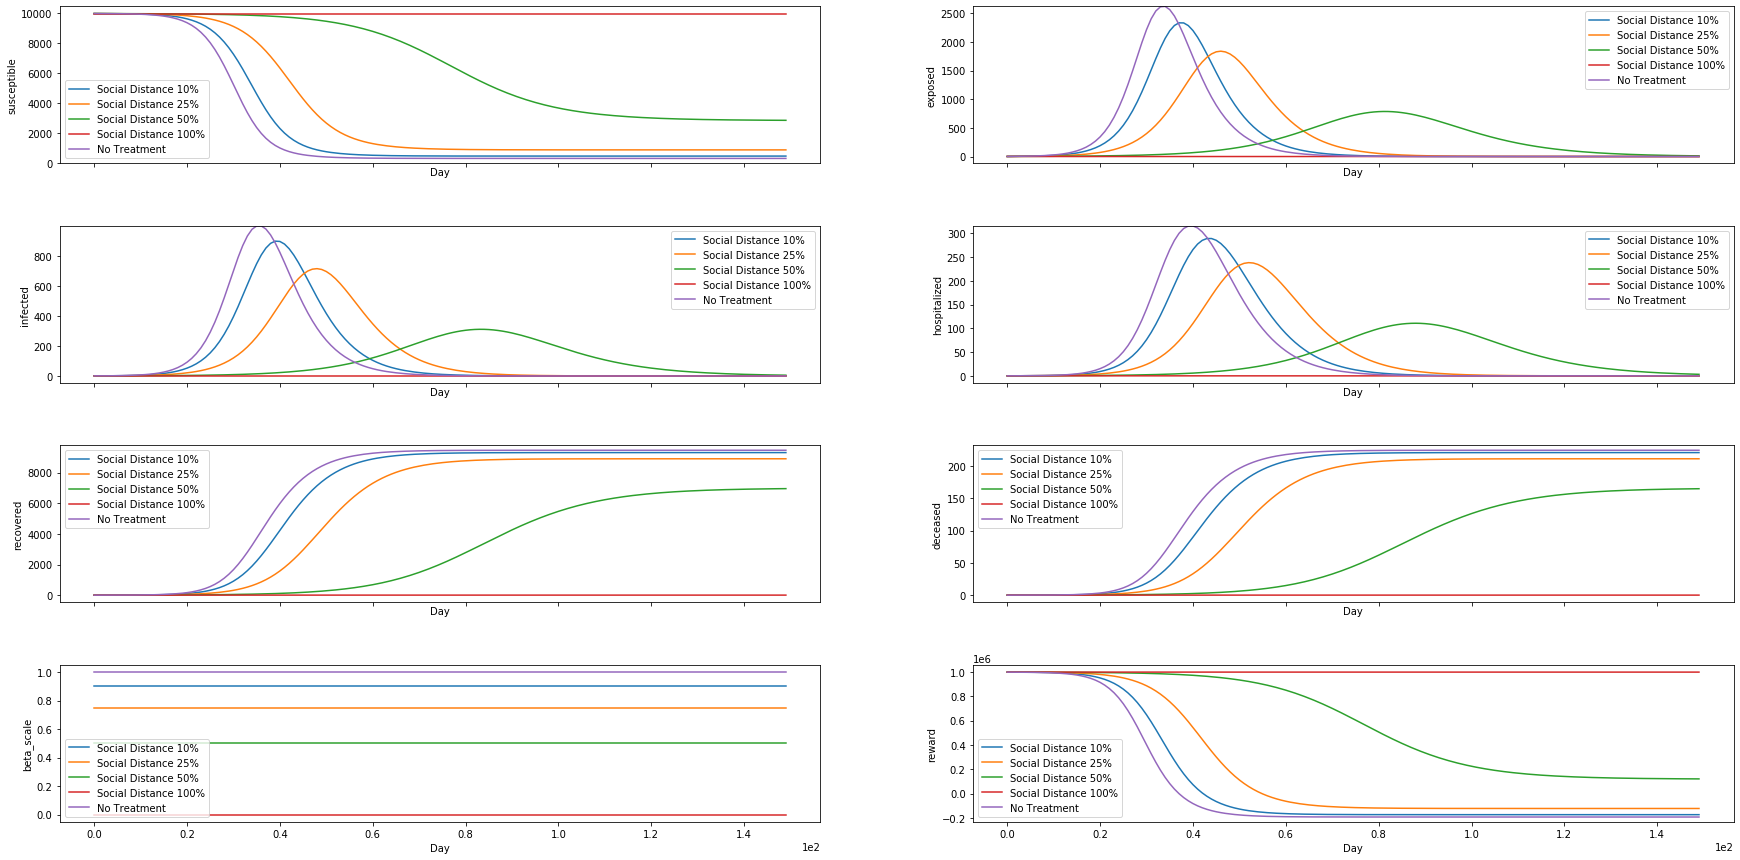

In [13]:
plot_sample_trajectory(env, augment_policies(policies, NoTreatmentPolicy(), policy_name="No Treatment"))

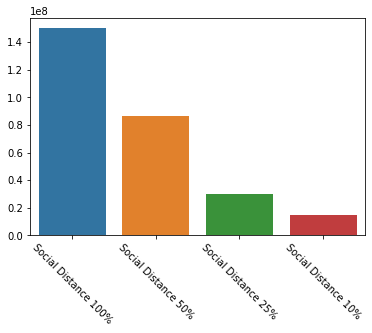

In [14]:
plot_reward_bars(env, policies)

### Comparison of Policies on the Basic Environment

As we can see, with no associated costs for implementing social distancing, the best option for us is to perform 100% Social Distancing - this ensures that nobody transitions beyond the susceptible stage, and has the highest reward.

However, for more practical policies, we can observe that even a difference from 10% to 25% social distancing flattens the curve significantly more. 

# Introduction of a Confounder

![Confounder](figs/confounder.png)

We now wish to demonstrate the effect of an unobserved confounder on reinforcement learning. In the examples that follow we have **location** as an unobserved confounder. Our action space still remains the same, that is it is still the strength of social distancing applied to the environment, however now we introduce two new variables to our environment:

1. **Non-adherence factor**: Non-adherence is the amount of social distancing policy violation in a given environment.
2. **Economic cost of social distancing**: You can interpret is as the lost economic output as a function of the amount of social distancing applied

These added variables now allow us to change the action space and the reward space. We demonstrate the effect of the confounder with the following fictional examples. We posit that a location with a high economic output will have a higher propensity to adhere to social distancing and also have a higher cost to social distancing.

Accordingly, we demonstrate these effects using the following environments, we can consider these 2 distinct locations as examples:

1. **San Francisco, CA**: A tech haven which has a high economic contribution per capita, where furloughs and transitions to remote work are easier to implement. This location would have a high adherence to social distancing policies, but also a high cost of social distancing
2. **Birmingham, AL**: A manufacturing city where steel plants play a central role in the economy, and the economic contribution per capita is comparitively low. This location would have lower adherence to social distancing policies, but a low cost of implementation.

---

### Confounded action space

Our non-adherence is implemented as a function of social distancing levied to a location, we imaging that if no social distancing is applied there is zero non-adherence. Accordingly we define a non-adherence factor ($\eta$) as follows:

$$\text{current social distancing} = \text{current social distancing}(1 - \eta)$$

and $\eta = 0.1$ for **Ruralwood** and $\eta = 0.1$ for **Dollarville**

### Confounder Reward:
A reward function that weighs the costs and benefits of controlling COVID-19.

$$\text{reward} = \text{value of individual} * (\text{-state.deceased + state.susceptible}) - \text{economic output per time} * \text{current social distancing}$$

This reward function is a simple linear function that aims to minimize deaths from the virus, as well as the cost of controlling its spread.

## Let's take a Dollarville

In this environment, there there is a cost to losing people to COVID, but there is a much higher cost associated with social distancing because of the high economic output of this place - so social distancing is very expensive in this location.

Once we train our policy on this specific environment, we hope to see the policy learning to avoid stricter social distancing rules, while keeping the spread in check.

In [15]:
import whynot.simulators.covid19.environments.rich_place_env

In [16]:
rich_env = gym.make('COVID19-RICH-v0')
rich_env.seed(1);


## Policy Gradient

For a given state $s$, a policy can be written as a probability distribution $\pi_\theta(s, a)$ over actions $a$, where $\theta$ represents the parameters the policy.

The objective here is to learn a $\theta^*$ that maximizes the objective function

   $\;\;\;\; J(\theta) = E_{\tau \sim \pi_\theta}[r(\tau)]$,

where $\tau$ is the trajectory sampled according to policy $\pi_\theta$ and $r(\tau)$ is the discounted sum of rewards on $\tau$.

The policy gradient approach is to take the gradient of this objective

$ \nabla_\theta J(\theta) = \nabla_\theta \int \pi_\theta(\tau)r(\tau)d\tau = \int \pi_\theta(\tau) \nabla_\theta \log\pi_\theta(\tau)r(\tau)d\tau \\
= E_{\tau \sim \pi_\theta(\tau)}[\nabla_\theta \log \pi_\theta(\tau)r(\tau)] $

A helpful link about Policy Gradients: https://towardsdatascience.com/policy-gradients-in-a-nutshell-8b72f9743c5d

*****Iteration 0*****
*****Iteration 10*****
*****Iteration 20*****
*****Iteration 30*****
*****Iteration 40*****
*****Iteration 50*****
*****Iteration 60*****
*****Iteration 70*****
*****Iteration 80*****
*****Iteration 90*****
*****Iteration 100*****
*****Iteration 110*****
*****Iteration 120*****
*****Iteration 130*****
*****Iteration 140*****


/Users/chintanshah/courses/cs7290/project/whynot/examples/reinforcement_learning/scripts/utils.py:236: UserWarning: Attempting to set identical bottom == top == 150.0 results in singular transformations; automatically expanding.
  ax3.set_ylim(avg_episode_lengths.min(), avg_episode_lengths.max())


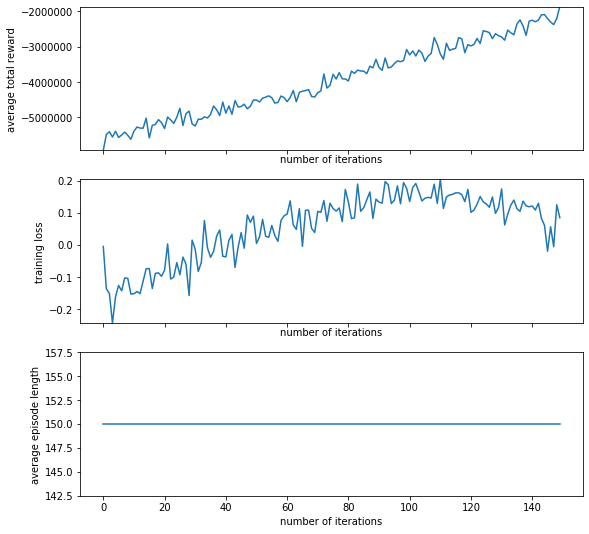

In [17]:
rich_learned_policy = utils.run_training_loop(env=rich_env, n_iter=n_iter, max_episode_length=150, batch_size=1000, learning_rate=1e-3)

Total reward for Social Distance 10%: -1118729.88
Total reward for Social Distance 25%: -3220837.50
Total reward for Social Distance 50%: -6472172.00
Total reward for Social Distance 100%: -13350316.00
Total reward for learned_policy: -1879087.62


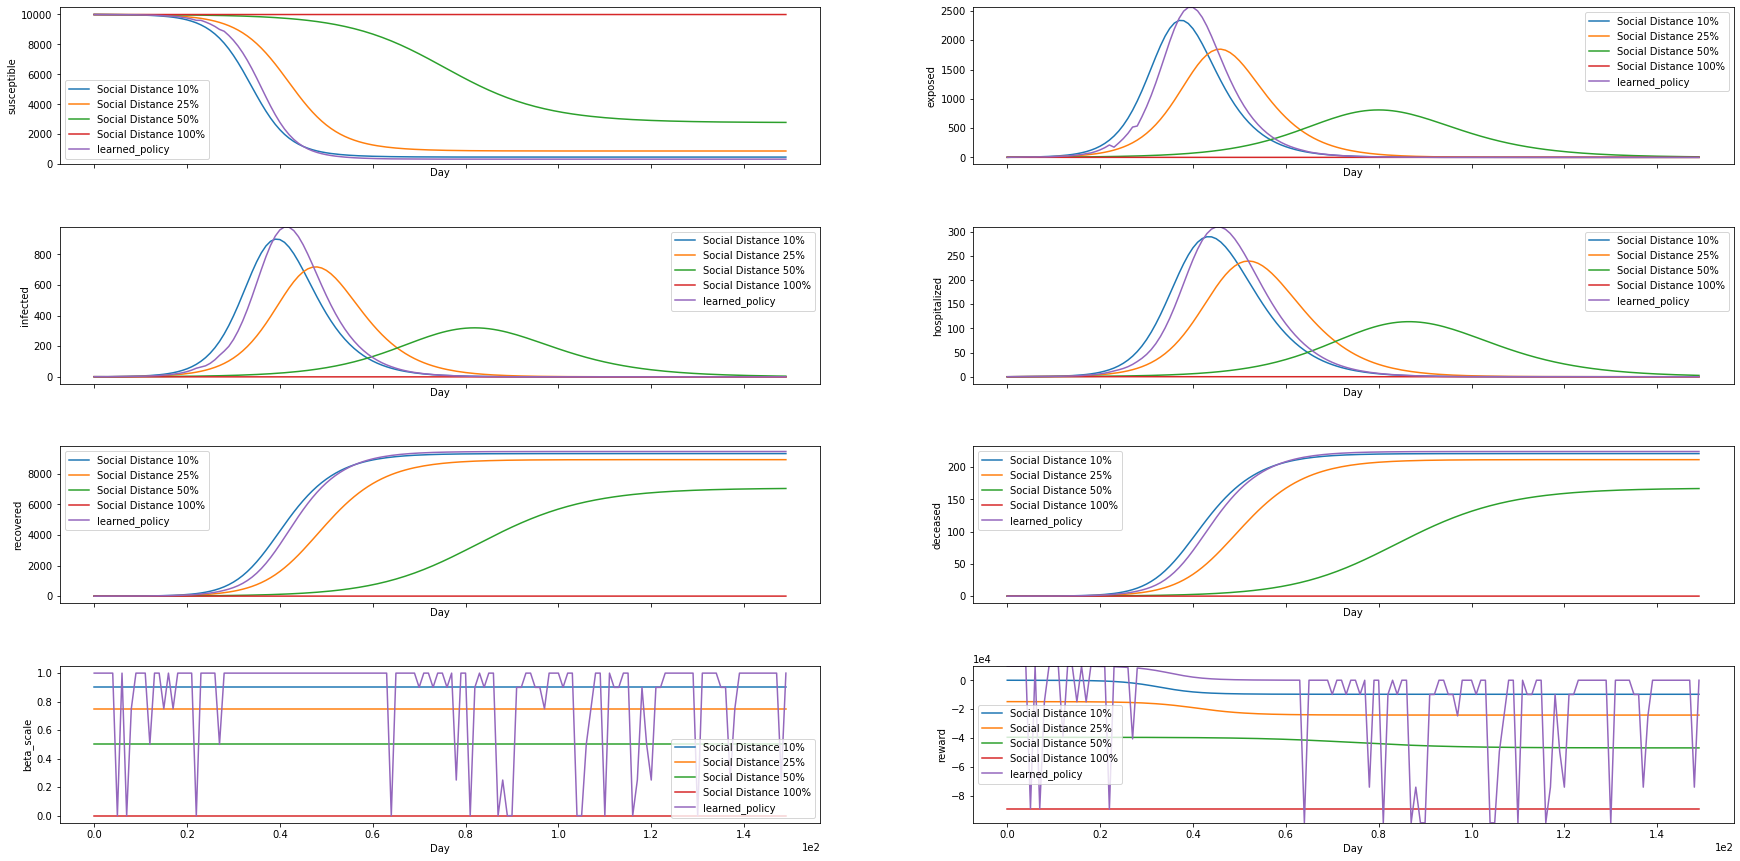

In [18]:
plot_sample_trajectory(rich_env, augment_policies(policies, rich_learned_policy))

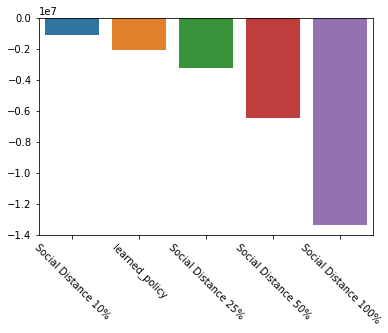

In [19]:
plot_reward_bars(rich_env, augment_policies(policies, rich_learned_policy))

## Now we look at Ruralwood

This place has the same human cost - that is the cost of an individual dying, however this location does not produce nearly as much economic output and so it can afford social distancing practices and we see that the model learns that

In [20]:
import whynot.simulators.covid19.environments.poor_place_env

In [21]:
poor_env = gym.make('COVID19-POOR-v0')
poor_env.seed(1);

*****Iteration 0*****
*****Iteration 10*****
*****Iteration 20*****
*****Iteration 30*****
*****Iteration 40*****
*****Iteration 50*****
*****Iteration 60*****
*****Iteration 70*****
*****Iteration 80*****
*****Iteration 90*****
*****Iteration 100*****
*****Iteration 110*****
*****Iteration 120*****
*****Iteration 130*****
*****Iteration 140*****


/Users/chintanshah/courses/cs7290/project/whynot/examples/reinforcement_learning/scripts/utils.py:236: UserWarning: Attempting to set identical bottom == top == 150.0 results in singular transformations; automatically expanding.
  ax3.set_ylim(avg_episode_lengths.min(), avg_episode_lengths.max())


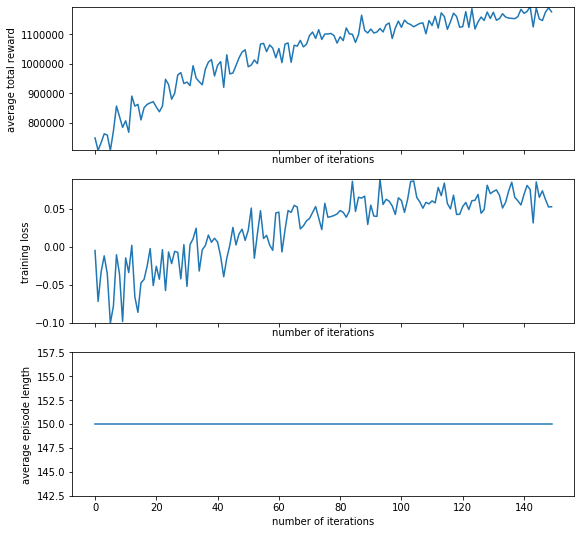

In [22]:
poor_learned_policy = utils.run_training_loop(env=poor_env, n_iter=n_iter, max_episode_length=150, batch_size=1000, learning_rate=1e-3)

Total reward for Social Distance 10%: 360347.41
Total reward for Social Distance 25%: 467922.16
Total reward for Social Distance 50%: 828001.38
Total reward for Social Distance 100%: 1498187.88
Total reward for learned_policy: 1292229.25


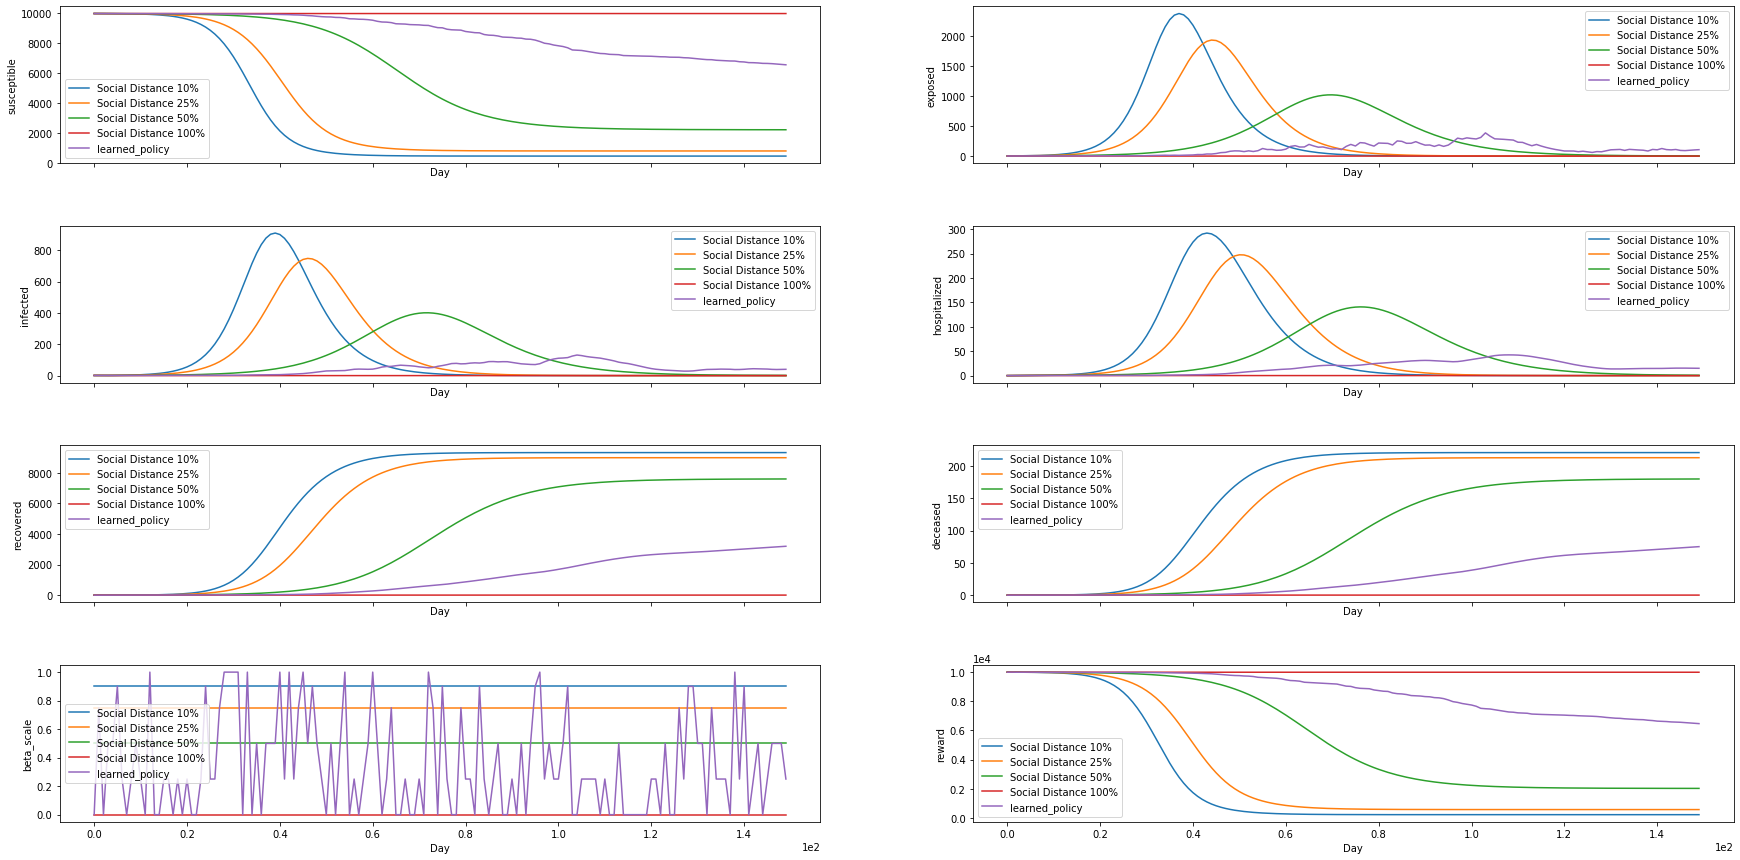

In [23]:
plot_sample_trajectory(poor_env, augment_policies(policies, poor_learned_policy))

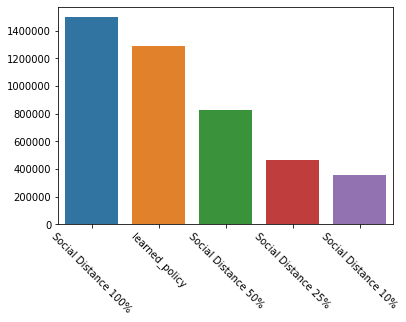

In [24]:
plot_reward_bars(poor_env, augment_policies(policies, poor_learned_policy))

## Confounded environment

All of the environments have an unobserved confounder - that is a location that dictates the cost of social distancing and the rewards that you get - however the confounder level is fixed in the earlier examples.

In this example, the confounder level varies

In [25]:
import whynot.simulators.covid19.environments.confounded_env

In [26]:
confounded_env = gym.make('COVID19-CONFOUNDED-v0')
confounded_env.seed(1);

*****Iteration 0*****
*****Iteration 10*****
*****Iteration 20*****
*****Iteration 30*****
*****Iteration 40*****
*****Iteration 50*****
*****Iteration 60*****
*****Iteration 70*****
*****Iteration 80*****
*****Iteration 90*****
*****Iteration 100*****
*****Iteration 110*****
*****Iteration 120*****
*****Iteration 130*****
*****Iteration 140*****


/Users/chintanshah/courses/cs7290/project/whynot/examples/reinforcement_learning/scripts/utils.py:236: UserWarning: Attempting to set identical bottom == top == 150.0 results in singular transformations; automatically expanding.
  ax3.set_ylim(avg_episode_lengths.min(), avg_episode_lengths.max())


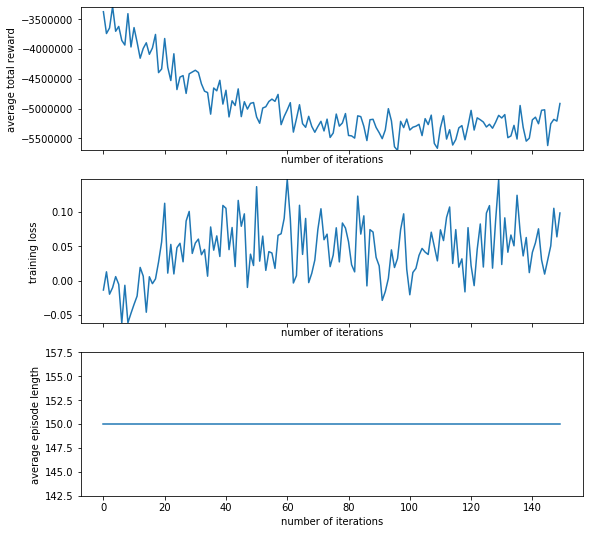

In [27]:
confounded_learned_policy = utils.run_training_loop(env=confounded_env, n_iter=n_iter, max_episode_length=150, batch_size=1000, learning_rate=1e-3)

Total reward for Social Distance 10%: -712688.94
Total reward for Social Distance 25%: -2025095.25
Total reward for Social Distance 50%: -4617554.50
Total reward for Social Distance 100%: -8418810.00
Total reward for learned_policy: -4743454.50


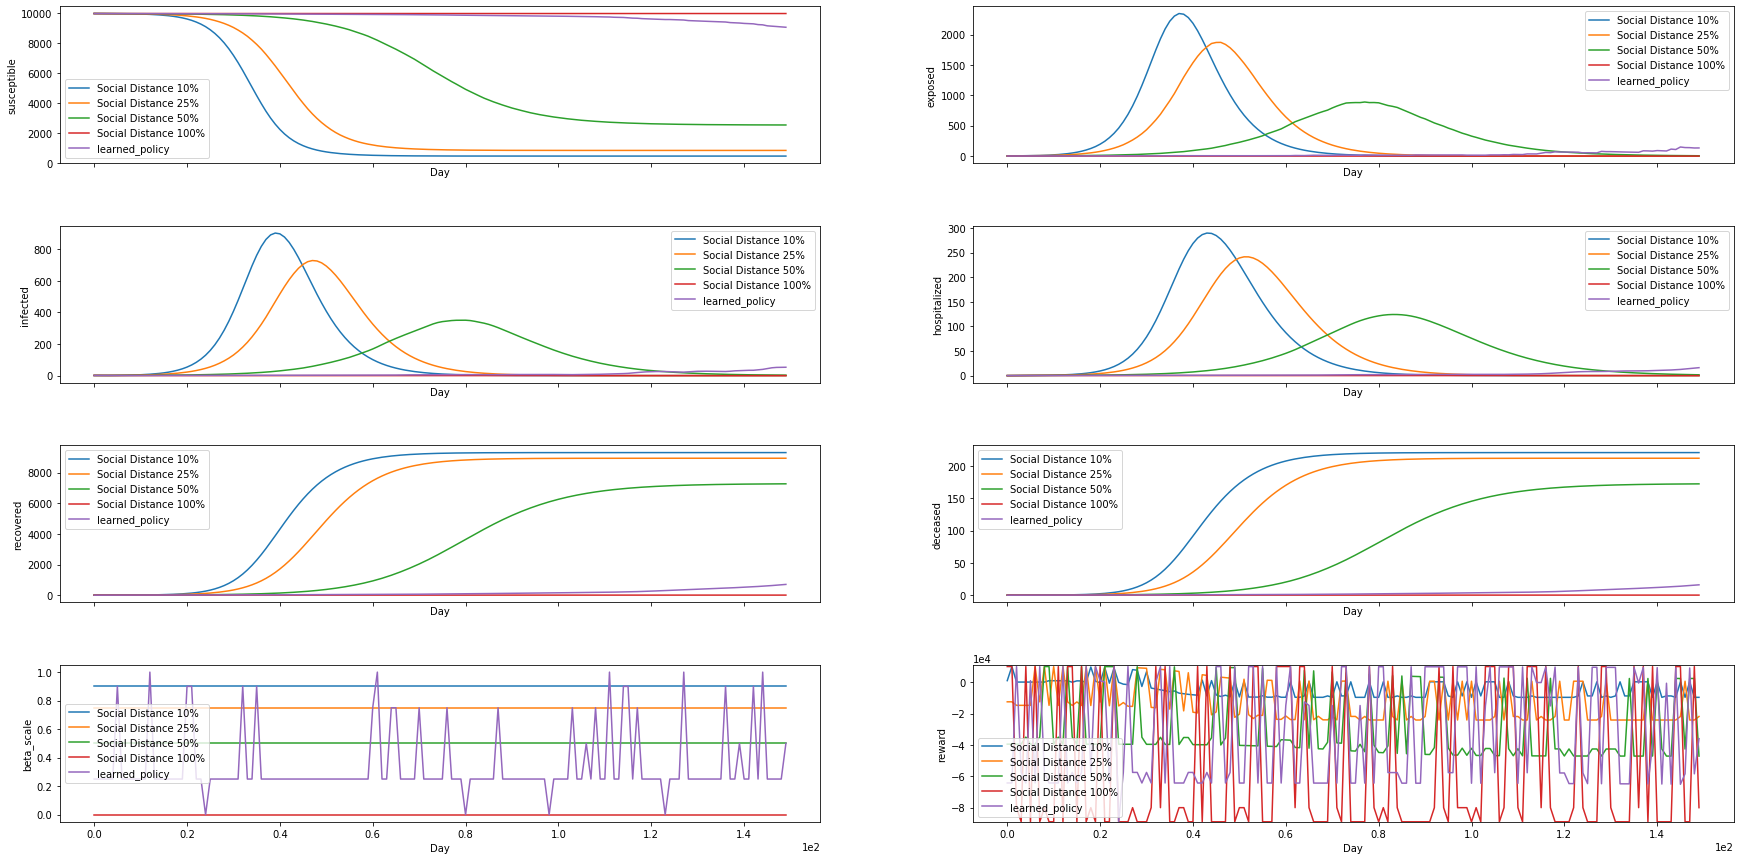

In [28]:
plot_sample_trajectory(confounded_env, augment_policies(policies, confounded_learned_policy))

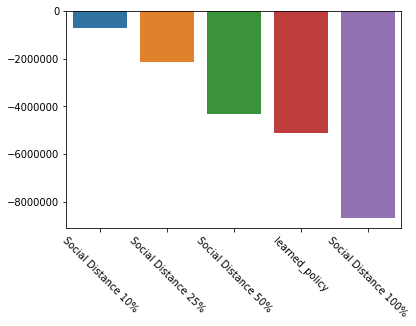

In [29]:
plot_reward_bars(confounded_env, augment_policies(policies, confounded_learned_policy))

### Possible extension:

One possible extension to this idea is a stochastic action space. Currently our action space is deterministic - we can have an action space where we sample an action with some probability. What this will allow us to do is have a location that confounds both the action and the reward.

Let me give you an example:

According to our earlier definition - India will not have a very high economic output as the US and so it can afford social distancing and so it's number of deaths are lower. However, social distancing is just a policy that is enacted - in a place like India, people may not follow such policies and hence social distancing can never reach 100% like our models. So instead of having a fixed action space, if we were to sample an action from a stochastic policy set, we can sample 100% social distancing say 90% of the time and 10% of the time, select any other policy - like 10% social distancing.

An RL agent will never be able to understand what is happening. As the place is a confounder - we can have the place determine just how much social distancing is possible and what is the cost of social distancing

References:

1. https://wwwnc.cdc.gov/eid/article/26/6/20-0233_article
2. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6332839/